In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely import wkt
from shapely.geometry import Point, box
import datetime as dt

In [37]:
nodes = pd.read_csv("node_data.csv")
edges = pd.read_csv("data/edges_data.csv")
df_2020 = pd.read_csv("data/scats_detector_volume_jan-jun-2020.csv")
sites = pd.read_csv("data/its_scats_sites_aug-2020.csv")

In [38]:
columns_to_load = ["End_Time", "Site", "Detector", "Sum_Volume", "Avg_Volume"]
March2025 = pd.read_csv("data/SCATSMarch2025.csv", usecols=columns_to_load)

In [39]:
April2025 = pd.read_csv("data/SCATSApril2025.csv", usecols=columns_to_load)

In [40]:
May2025 = pd.read_csv("data/SCATSMay2025.csv", usecols=columns_to_load)

In [41]:
df  = pd.concat([March2025, April2025], ignore_index=True)

In [42]:
geo_edges=edges.copy()
# Convert the 'geometry' column from WKT to Shapely geometries
geo_edges['geometry'] = edges['geometry'].apply(wkt.loads)

# Wrap as a GeoDataFrame
geo_edges = gpd.GeoDataFrame(geo_edges, geometry='geometry')

# Set the CRS (optional, replace with your CRS if known)
geo_edges.set_crs(epsg=4326, inplace=True)

# Now this is a true GeoDataFrame
print(type(geo_edges))

<class 'geopandas.geodataframe.GeoDataFrame'>


In [43]:
geo_nodes=nodes.copy()
# Convert the 'geometry' column from WKT to Shapely geometries
geo_nodes['geometry'] = nodes['geometry'].apply(wkt.loads)

# Wrap as a GeoDataFrame
geo_nodes = gpd.GeoDataFrame(geo_nodes, geometry='geometry')

# Set the CRS (optional, replace with your CRS if known)
geo_nodes.set_crs(epsg=4326, inplace=True)

# Now this is a true GeoDataFrame
print(type(geo_nodes))

<class 'geopandas.geodataframe.GeoDataFrame'>


In [44]:
sites = sites[~((sites["Lat"] == 0) | (sites["Long"] == 0))]
geo_sites = gpd.GeoDataFrame(
    sites,
    geometry=gpd.points_from_xy(sites['Long'], sites['Lat']),
    crs="EPSG:4326"  # WGS84 coordinate system (lat/long)
)

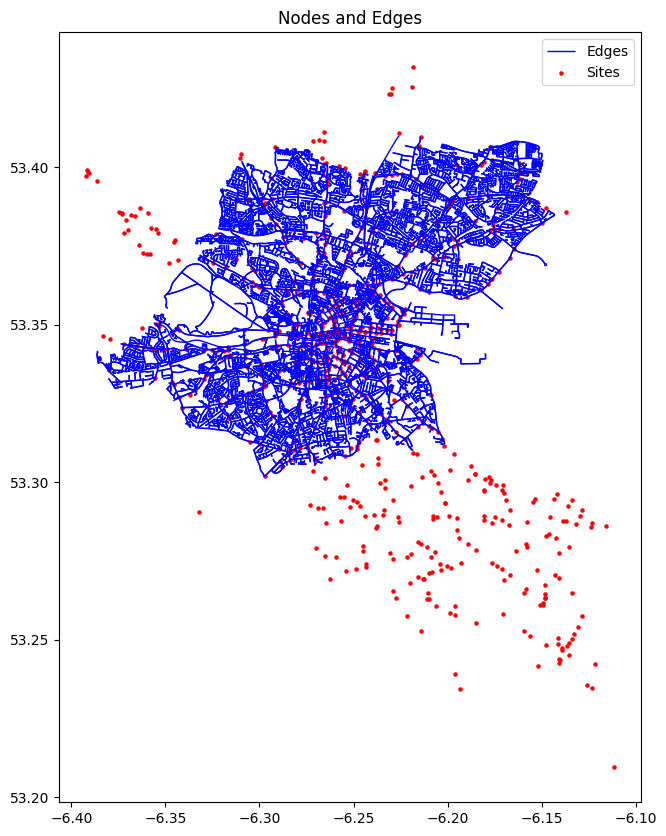

In [45]:
fig, ax = plt.subplots(figsize=(10, 10))

# Plot edges first (usually as lines)
geo_edges.plot(ax=ax, color='blue', linewidth=1, label='Edges')

# Plot nodes on top (usually as points)
geo_sites.plot(ax=ax, color='red', markersize=5, label='Sites')

# Optional: add a legend and title
plt.legend()
plt.title("Nodes and Edges")

plt.show()

In [46]:
# Get bounding box of all points
minx, miny, maxx, maxy = geo_edges.total_bounds

# Define grid size (in the CRS units, e.g., degrees if EPSG:4326)
nx = 10  # number of columns
ny = 10  # number of rows
xgrid = np.linspace(minx, maxx, nx+1)
ygrid = np.linspace(miny, maxy, ny+1)

# Create grid polygons
polygons = []
for i in range(nx):
    for j in range(ny):
        polygons.append(box(xgrid[i], ygrid[j], xgrid[i+1], ygrid[j+1]))

grid = gpd.GeoDataFrame({'geometry': polygons}, crs=geo_edges.crs)

In [47]:
df_small = df[["End_Time","Site","Sum_Volume"]]  # only necessary columns
geo_small = geo_sites[['SiteID', 'geometry']]
df_small['Site'] = df_small['Site'].astype('category')
geo_small['SiteID'] = geo_small['SiteID'].astype('category')

C:\Users\user1\AppData\Local\Temp\ipykernel_1548\2462526846.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_small['Site'] = df_small['Site'].astype('category')
c:\Users\user1\AppData\Local\Programs\Python\Python313\Lib\site-packages\geopandas\geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [48]:
gdf = pd.merge(df_small, geo_small, left_on ="Site", right_on = "SiteID", how = "inner")

gdf.head()


,End_Time,Site,Sum_Volume,SiteID,geometry
0,20250313010000,58,0,58.0,POINT (-6.26523 53.35605)
1,20250313010000,58,5,58.0,POINT (-6.26523 53.35605)
2,20250313010000,58,0,58.0,POINT (-6.26523 53.35605)
3,20250313010000,58,0,58.0,POINT (-6.26523 53.35605)
4,20250313010000,58,0,58.0,POINT (-6.26523 53.35605)


In [49]:
gdf=gdf.drop("SiteID", axis = 1)
gdf["End_Time"] = pd.to_datetime(gdf["End_Time"], format="%Y%m%d%H%M%S")
gdf.head()

,End_Time,Site,Sum_Volume,geometry
0,2025-03-13 01:00:00,58,0,POINT (-6.26523 53.35605)
1,2025-03-13 01:00:00,58,5,POINT (-6.26523 53.35605)
2,2025-03-13 01:00:00,58,0,POINT (-6.26523 53.35605)
3,2025-03-13 01:00:00,58,0,POINT (-6.26523 53.35605)
4,2025-03-13 01:00:00,58,0,POINT (-6.26523 53.35605)


In [50]:
gdf = gpd.GeoDataFrame(
    gdf,
    geometry=gdf["geometry"],
    crs="EPSG:4326"  # WGS84 coordinate system (lat/long)
)

In [51]:
# Spatial join points to grid boxes
joined = gpd.sjoin(gdf, grid, how='left', predicate='within')

# Sum Sum_volume per grid cell
grid_sum = joined.groupby('index_right')['Sum_Volume'].sum()

# Assign sums to the grid GeoDataFrame
grid['Sum_volume'] = grid_sum
grid['Sum_volume'] = grid['Sum_volume'].fillna(0)  # fill empty cells


In [61]:
grid.index.name = "Grid_ID"
grid.head()

#grid.set_index("Grid_ID", inplace=True)

,geometry,Sum_volume
Grid_ID,,
0,"POLYGON ((-6.36199 53.3018, -6.36199 53.31262,...",0.0
1,"POLYGON ((-6.36199 53.31262, -6.36199 53.32344...",0.0
2,"POLYGON ((-6.36199 53.32344, -6.36199 53.33426...",0.0
3,"POLYGON ((-6.36199 53.33426, -6.36199 53.34507...",1857254.0
4,"POLYGON ((-6.36199 53.34507, -6.36199 53.35589...",2035809.0


In [52]:
joined_eval = joined.groupby(["index_right","End_Time"]).agg({
    "Sum_Volume": "sum"
}).reset_index()
joined_eval.head()

,index_right,End_Time,Sum_Volume
0,3.0,2025-03-01 00:00:00,897
1,3.0,2025-03-01 01:00:00,551
2,3.0,2025-03-01 02:00:00,492
3,3.0,2025-03-01 03:00:00,272
4,3.0,2025-03-01 04:00:00,247


In [53]:
joined_eval = joined_eval.rename(columns={"index_right": "Grid_ID"})


In [54]:
joined_eval = joined_eval.sort_values("Grid_ID")
joined_eval.head()

,Grid_ID,End_Time,Sum_Volume
0,3.0,2025-03-01 00:00:00,897
1,3.0,2025-03-01 01:00:00,551
2,3.0,2025-03-01 02:00:00,492
3,3.0,2025-03-01 03:00:00,272
4,3.0,2025-03-01 04:00:00,247


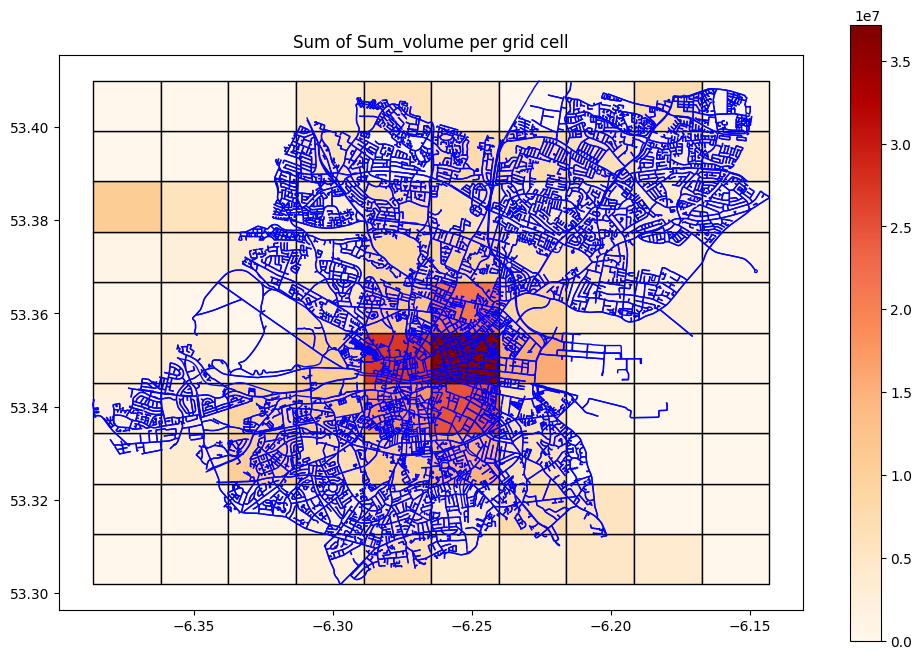

In [55]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
grid.plot(column='Sum_volume', ax=ax, cmap='OrRd', legend=True, edgecolor='k')
geo_edges.plot(ax=ax, color='blue', linewidth=1, label='Edges')
plt.title("Sum of Sum_volume per grid cell")
plt.show()

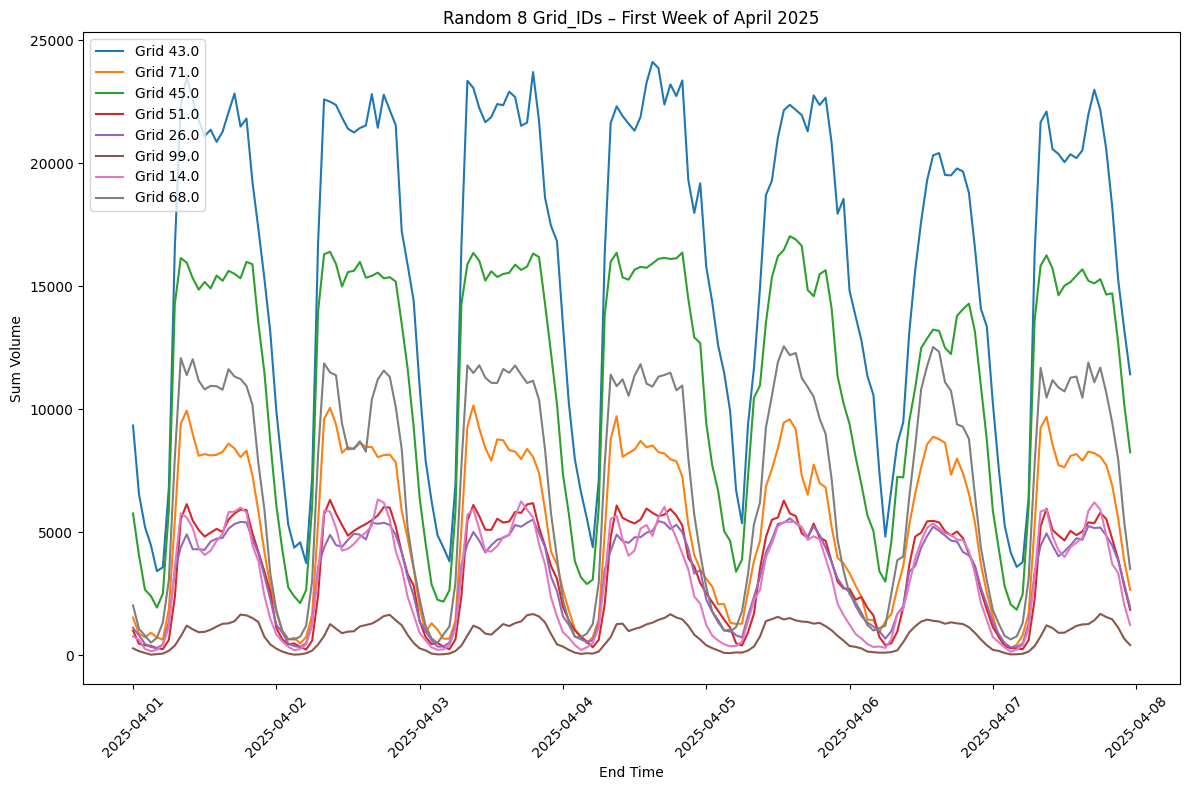

In [56]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 1. Define the time window (first week of April 2025)
start = pd.Timestamp("2025-04-01")
end   = pd.Timestamp("2025-04-07 23:59:59")

# 2. Filter the data for that week
week_data = joined_eval[(joined_eval["End_Time"] >= start) & (joined_eval["End_Time"] <= end)]

# 3. Pick 8 random Grid_IDs from those available in that week
random_ids = np.random.choice(week_data["Grid_ID"].unique(), size=8, replace=False)

# 4. Filter again for just those IDs
subset = week_data[week_data["Grid_ID"].isin(random_ids)]

# 5. Plot
plt.figure(figsize=(12, 8))
for gid in random_ids:
    temp = subset[subset["Grid_ID"] == gid]
    plt.plot(temp["End_Time"], temp["Sum_Volume"], label=f"Grid {gid}")

plt.xlabel("End Time")
plt.ylabel("Sum Volume")
plt.title("Random 8 Grid_IDs – First Week of April 2025")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [63]:
bins = [0, 7, 10, 16, 20, 24]  # hours
labels = ["00-07", "07-10", "10-16", "16-20", "20-24"]

# extract hour of day
joined_eval["hour"] = joined_eval["End_Time"].dt.hour

# assign each row into a time bin
joined_eval["time_bin"] = pd.cut(joined_eval["hour"], bins=bins, labels=labels, right=False)

# also extract just the date (for grouping day by day)
joined_eval["date"] = joined_eval["End_Time"].dt.date

# now group by Grid_ID, date, and time_bin
grouped = (
    joined_eval
    .groupby(["Grid_ID", "date", "time_bin"])["Sum_Volume"]
    .sum()
    .reset_index()
)

grouped.head()

C:\Users\user1\AppData\Local\Temp\ipykernel_1548\1597695665.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["Grid_ID", "date", "time_bin"])["Sum_Volume"]


,Grid_ID,date,time_bin,Sum_Volume
0,3.0,2025-03-01,00-07,2877
1,3.0,2025-03-01,07-10,3029
2,3.0,2025-03-01,10-16,20766
3,3.0,2025-03-01,16-20,12818
4,3.0,2025-03-01,20-24,7405


In [64]:
grouped = pd.merge(grouped, grid, left_on="Grid_ID", right_index=True, how="left")
grouped.drop(columns=["Sum_volume"], inplace=True)
grouped.head()

,Grid_ID,date,time_bin,Sum_Volume,geometry
0,3.0,2025-03-01,00-07,2877,"POLYGON ((-6.36199 53.33426, -6.36199 53.34507..."
1,3.0,2025-03-01,07-10,3029,"POLYGON ((-6.36199 53.33426, -6.36199 53.34507..."
2,3.0,2025-03-01,10-16,20766,"POLYGON ((-6.36199 53.33426, -6.36199 53.34507..."
3,3.0,2025-03-01,16-20,12818,"POLYGON ((-6.36199 53.33426, -6.36199 53.34507..."
4,3.0,2025-03-01,20-24,7405,"POLYGON ((-6.36199 53.33426, -6.36199 53.34507..."


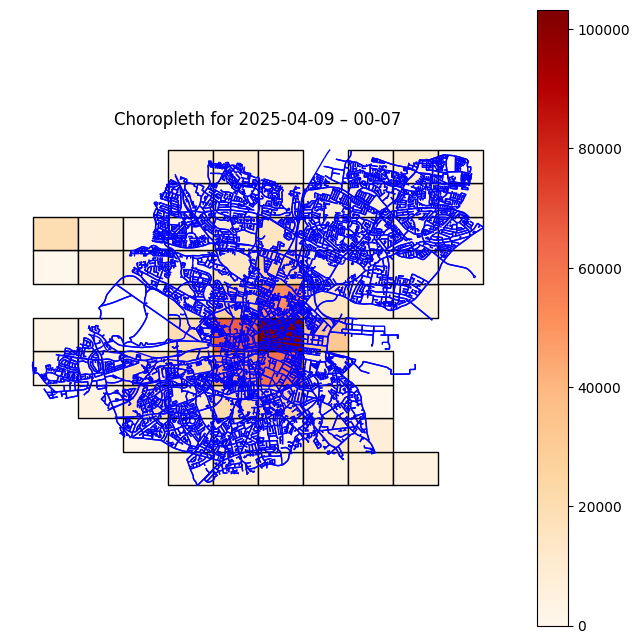

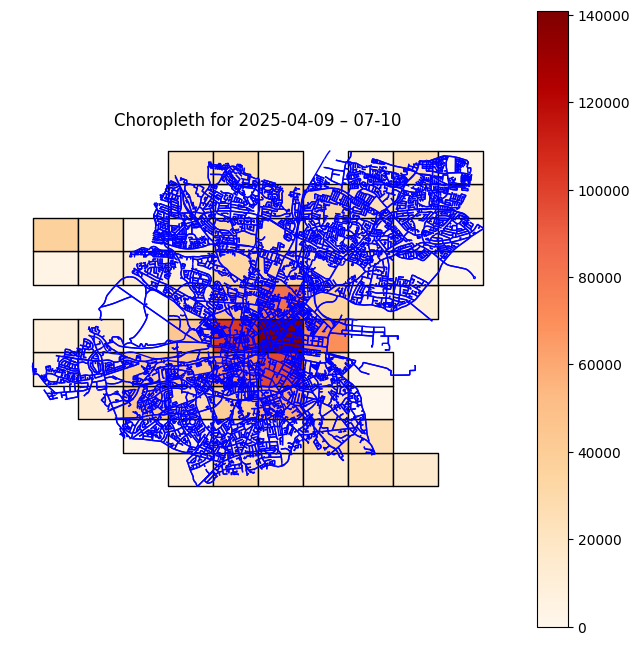

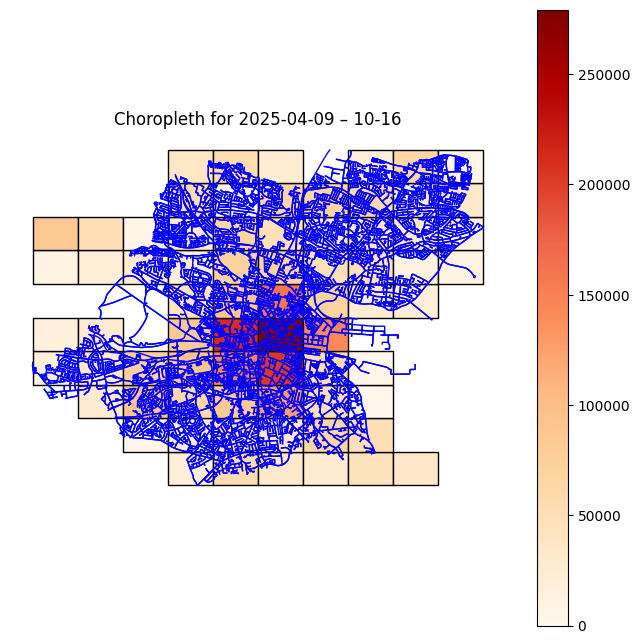

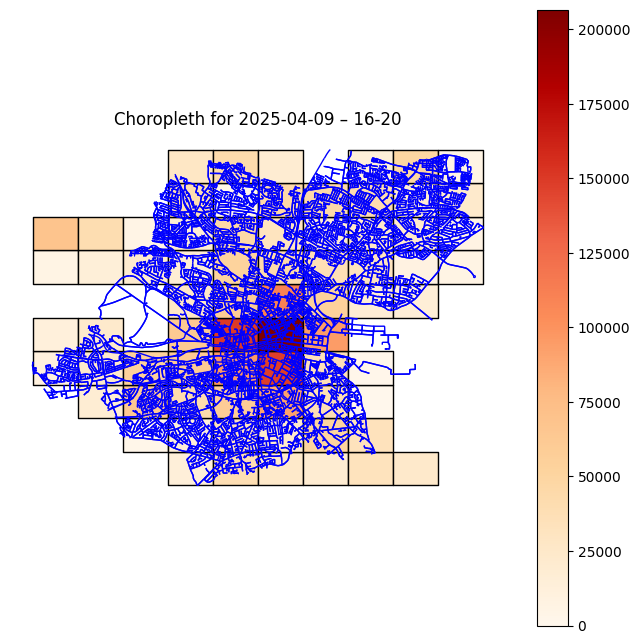

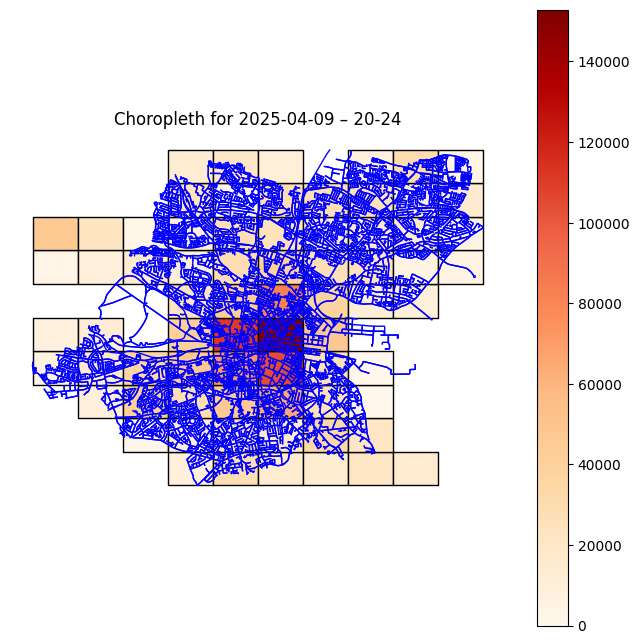

In [68]:
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd

# make sure grouped is a GeoDataFrame
grouped_gdf = gpd.GeoDataFrame(grouped, geometry="geometry")

# 1. pick a random day
random_day = np.random.choice(grouped_gdf["date"].unique())
day_data = grouped_gdf[grouped_gdf["date"] == random_day]

# 2. get the time bins for that day
time_bins = sorted(day_data["time_bin"].unique())

# 3. loop over each time bin and plot separately
for tb in time_bins:
    subset = day_data[day_data["time_bin"] == tb]

    fig, ax = plt.subplots(figsize=(8, 8))
    
    # plot choropleth
    subset.plot(
        column="Sum_Volume",
        cmap="OrRd",
        legend=True,
        ax=ax,
        edgecolor="black"
    )
    
    # overlay geo_edges
    geo_edges.plot(ax=ax, color="blue", linewidth=1, label="Edges")
    
    ax.set_title(f"Choropleth for {random_day} – {tb}")
    ax.axis("off")
    plt.show()
